## Ocean Biogeochemical Dynamics Lab, Spring 2021
Doing simple seasonal decomposition of drivers of DIC and TA with SOCCOM floats by Nancy Williams

This assumes you have already become familiar with `OBD_SOCCOM_L3.ipynb` and `OBD_SOCCOM_CO2SYS.ipynb` notebooks.

SOCCOM website: https://soccom.princeton.edu/

In [21]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import seaborn as sns # this will change the look of pandas plots, too
import cartopy.crs as ccrs
import cartopy.feature
import seawater
import xarray as xr
from PyCO2SYS.api import CO2SYS_wrap as co2sys
# this forces matplotlib to print figures out here when you make plots
from IPython.display import Image

In [22]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (15, 9)
plt.rcParams['font.size'] = 18
#plt.rcParams['lines.linewidth'] = 3

In [23]:
# Define the directory where you want the figures to be saved
output_dir = 'generated/'
# you could use os.path.join() which adds slashes

In [24]:
# You can switch this to turn debugging on or off (True or False)
DEBUG = True

def debug (*args):
    """Call print() with arguments if DEBUG is True""" # preserves formatting
    if DEBUG:
        print(*args)

# Importing the dataset
We want to use Pandas' built-in read_csv function to import a single float data file into a pandas data frame called `flt`. Float 9254 is a good example float for this exercise, but you can pick any float from the snapshot. To pick another float you can go to the SOCCOM web page sensor status table http://soccom.ucsd.edu/floats/SOCCOM_sensor_stats.html and choose a float with lots of good data (i.e., more in the "#g" column than the "#b" columns for variables you're interested in analyzing. You can sort the columns on that webpage by clicking on the column header by which you wish to sort.

In [25]:
# Pick a float
floatnum = '9095' 
floatpath = 'SOCCOM_LoResQC_LIAR_22Dec2020_odvtxt/' # This is the folder where all the float data live
floatsuffix = 'SOOCNQC.TXT' # all of the Southern Ocean floats have the same suffix

# Change // comment symbols to #
# input file
fin = open(floatpath+floatnum+floatsuffix,'rt',encoding='UTF-8')

# output file to which we will write the result
fout = open('fltrem.txt','wt')

# this is a for loop
# for each line in the input file
for line in fin:
    # red and replace the string and write to the output file
    fout.write(line.replace('//','#'))
# close the files
fin.close()
fout.close()

flt = pd.read_csv(
    'fltrem.txt',
    delimiter='\t',
    comment='#',
    na_values=-1E10,
)

flt['date'] = pd.to_datetime(flt['mon/day/yr'] + ' ' + flt['hh:mm'])
debug(flt)

        Cruise  Station Type  mon/day/yr  hh:mm  Lon [°E]  Lat [°N]  QF  \
0      5904188        1    C  04/15/2014  06:56   210.110   -49.932   0   
1      5904188        1    C  04/15/2014  06:56   210.110   -49.932   0   
2      5904188        1    C  04/15/2014  06:56   210.110   -49.932   0   
3      5904188        1    C  04/15/2014  06:56   210.110   -49.932   0   
4      5904188        1    C  04/15/2014  06:56   210.110   -49.932   0   
...        ...      ...  ...         ...    ...       ...       ...  ..   
10020  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   
10021  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   
10022  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   
10023  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   
10024  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   

       Pressure[dbar]  QF.1  ...  QF.14  pH25C[Total]  QF.15  \
0             1599.13   0.0  ...   

In [26]:
# Loop through all Quality Flag columns and apply them to the preceeding columns
from re import search
for column in range(len(flt.columns)):
    name=flt.columns[column]
    if search('QF',name): # if the column is a QF column, apply it to the preceeding column, otherwise go on to next column
        var=flt.columns[column-1]
        flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)

# Mapping your data
It's always a good idea to map your data and make sure it is where you think it is. Here we will use cartopy (basemap is deprecated).

Since we're talking about the Southern Ocean and there are stark fronts, it's good to plot your data in relation to these fronts. The climatological locations of the fronts are available from Orsi et al. (1995) https://www.sciencedirect.com/science/article/pii/096706379500021W. Text files containing the locations of the fronts are located in the "fronts" folder.

>Orsi, A. H., Whitworth, T. I., & Nowlin, W. D. J. (1995). On the meridional extent and fronts of the Antarctic Circumpolar Current. Deep Sea Research Part I. https://doi.org/10.1016/0967-0637(95)00021-W

### Where is your float in relation to the fronts of the ACC?
The following code imports the longitudes and latitudes of the five fronts. There are some '%' values in the files which creates breaks in the fronts. If we did not keep these breaks, the fronts would plot across continents.

In [27]:
def read_front_csv(name):
    """read Orsi front csv file into pandas dataframe"""
    return pd.read_csv(
        f'fronts/{name}.txt', #fstrings
        header=None,
        sep='\s+',
        na_values='%',
        names=['lon', 'lat'],
    )

stf = read_front_csv('stf')
saf = read_front_csv('saf')
pf = read_front_csv('pf')
saccf = read_front_csv('saccf')
sbdy = read_front_csv('sbdy')

The following is an example of a South Polar Stereographic map using Cartopy https://scitools.org.uk/cartopy/docs/latest/#. Polar stereographic maps are always a bit more complicated because you have to translate your coordinates to polar coordinates.

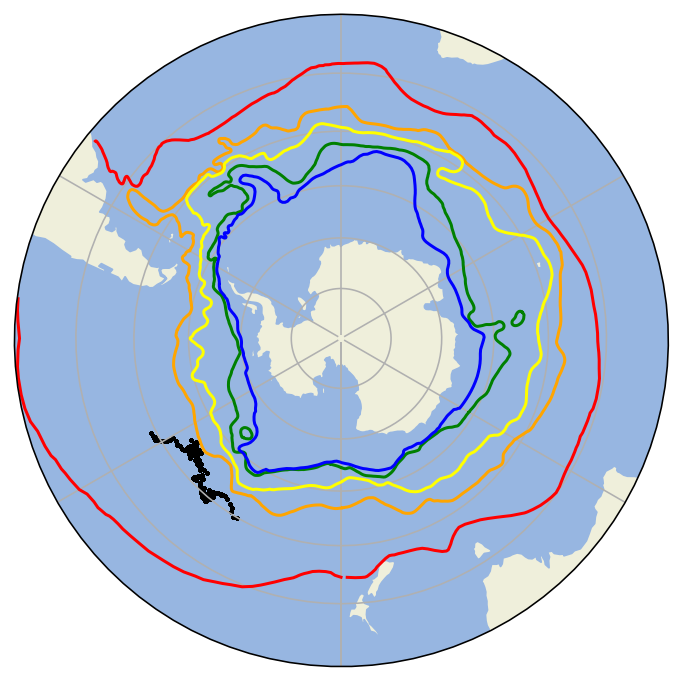

In [28]:
plt.figure(figsize =(6, 6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180,180,-90,-30], ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.gridlines()

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform = ax.transAxes)
plt.plot(stf['lon'], stf['lat'], color='Red', transform=ccrs.PlateCarree())
plt.plot(saf['lon'], saf['lat'], color='Orange', transform=ccrs.PlateCarree())
plt.plot(pf['lon'], pf['lat'], color='Yellow', transform=ccrs.PlateCarree())
plt.plot(saccf['lon'], saccf['lat'], color='Green', transform=ccrs.PlateCarree())
plt.plot(sbdy['lon'], sbdy['lat'], color='Blue', transform=ccrs.PlateCarree())

plt.scatter(flt['Lon [°E]'],flt['Lat [°N]'], color='Black', transform=ccrs.PlateCarree(), s=1)
plt.savefig(output_dir + 'F' +floatnum + 'map.png') 
plt.savefig(output_dir + 'F' +floatnum + 'map.jpg') # Changing the suffix will change the format
plt.show()

In [29]:
# Calculate MLD for each station
MLD = []
for station in flt['Station'].unique():
    surfacedens = flt['Sigma_theta[kg/m^3]'].loc[(flt['Station']==station)].min()
    MLD.append(
        [station,flt['date'].loc[(flt['Station']==station)&
                                 (flt['Sigma_theta[kg/m^3]']-surfacedens>0.03)].min(),
         flt['Depth[m]'].loc[(flt['Station']==station)&
                             (flt['Sigma_theta[kg/m^3]']-surfacedens>0.03)].min(),
         flt['Lon [°E]'].loc[(flt['Station']==station)].mean(),
         flt['Lat [°N]'].loc[(flt['Station']==station)].mean()])

# Take a look at MLD. First column is the Station, second column is datenum, second column is the MLD
MLD = pd.DataFrame(data=MLD, columns=['Station', 'date', 'MLD','Lon [°E]','Lat [°N]'])
debug(MLD)

     Station                date      MLD  Lon [°E]  Lat [°N]
0          1 2014-04-15 06:56:00   21.444   210.110   -49.932
1          2 2014-04-20 13:16:00  100.123   211.307   -49.675
2          3 2014-04-25 21:21:00   95.430   212.349   -50.213
3          4 2014-05-01 04:08:00  100.259   212.631   -50.992
4          5 2014-05-06 10:45:00  100.354   213.899   -51.417
..       ...                 ...      ...       ...       ...
150      169 2017-12-13 13:16:00   66.092   241.806   -49.233
151      170 2017-12-23 14:22:00   25.629   241.826   -49.184
152      171 2018-01-02 13:34:00   49.994   241.973   -49.364
153      172 2018-01-12 15:19:00   72.010   242.661   -49.112
154      173 2018-01-22 18:21:00   46.120   243.415   -49.121

[155 rows x 5 columns]


## Make a time series plot of average mixed layer observations
Here we first pull *only* the data from the mixed layer (shallower than MLD) and put into a separate dataframe called `fltSurf`. We then use the pandas groupby function to group and average the mixed layer data by station.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

In [30]:
fltSurf = pd.DataFrame()
for station in flt['Station'].unique():
    stationMLD = MLD.MLD[MLD.Station==station].values[0]
    mask = (flt['Station']==station) & (flt['Pressure[dbar]']<stationMLD)
    fltSurf = fltSurf.append(flt[mask])
debug(fltSurf)

        Cruise  Station Type  mon/day/yr  hh:mm  Lon [°E]  Lat [°N]  QF  \
63     5904188        1    C  04/15/2014  06:56   210.110   -49.932   0   
64     5904188        1    C  04/15/2014  06:56   210.110   -49.932   0   
65     5904188        1    C  04/15/2014  06:56   210.110   -49.932   0   
114    5904188        2    C  04/20/2014  13:16   211.307   -49.675   0   
115    5904188        2    C  04/20/2014  13:16   211.307   -49.675   0   
...        ...      ...  ...         ...    ...       ...       ...  ..   
10019  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   
10020  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   
10021  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   
10022  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   
10023  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   

       Pressure[dbar]  QF.1  ...  QF.14  pH25C[Total]  QF.15  \
63              16.58   0.0  ...   

In [31]:
# Use groupby to get average values for each station
fltSurfByStn = fltSurf.groupby('Station', as_index=False).mean()
debug(fltSurfByStn)

     Station   Cruise  Lon [°E]  Lat [°N]  QF  Pressure[dbar]  QF.1  \
0          1  5904188   210.110   -49.932   0       11.973333   0.0   
1          2  5904188   211.307   -49.675   0       47.541429   0.0   
2          3  5904188   212.349   -50.213   0       49.128333   0.0   
3          4  5904188   212.631   -50.992   0       51.590000   0.0   
4          5  5904188   213.899   -51.417   0       51.635263   0.0   
..       ...      ...       ...       ...  ..             ...   ...   
149      169  5904188   241.806   -49.233   0       35.449231   0.0   
150      170  5904188   241.826   -49.184   0       13.504000   0.0   
151      171  5904188   241.973   -49.364   0       27.811111   0.0   
152      172  5904188   242.661   -49.112   0       38.730000   0.0   
153      173  5904188   243.415   -49.121   0       24.141250   0.0   

     Temperature[°C]  QF.2  Salinity[pss]  ...  pHinsitu[Total]  QF.14  \
0          11.303900   0.0      34.463200  ...         8.102633    0.0   

In [33]:
# Groupby doesn't work on datetime column so it was dropped. We need to make a datetime array to be used with plotting
fltdates = []
for station in fltSurfByStn['Station'].unique():
    fltdates.append([flt['date'].loc[(flt['Station']==station)].min()])
debug(len(fltdates))
debug(type(fltdates))
fltdates

154
<class 'list'>


[[Timestamp('2014-04-15 06:56:00')],
 [Timestamp('2014-04-20 13:16:00')],
 [Timestamp('2014-04-25 21:21:00')],
 [Timestamp('2014-05-01 04:08:00')],
 [Timestamp('2014-05-06 10:45:00')],
 [Timestamp('2014-05-11 17:55:00')],
 [Timestamp('2014-05-17 01:23:00')],
 [Timestamp('2014-05-22 09:21:00')],
 [Timestamp('2014-05-27 16:22:00')],
 [Timestamp('2014-06-02 00:29:00')],
 [Timestamp('2014-06-07 12:04:00')],
 [Timestamp('2014-06-12 21:54:00')],
 [Timestamp('2014-06-18 04:18:00')],
 [Timestamp('2014-06-23 11:29:00')],
 [Timestamp('2014-06-28 18:11:00')],
 [Timestamp('2014-07-04 01:13:00')],
 [Timestamp('2014-07-09 07:15:00')],
 [Timestamp('2014-07-14 13:51:00')],
 [Timestamp('2014-07-19 20:52:00')],
 [Timestamp('2014-07-25 03:18:00')],
 [Timestamp('2014-07-30 09:34:00')],
 [Timestamp('2014-08-04 16:12:00')],
 [Timestamp('2014-08-10 01:40:00')],
 [Timestamp('2014-08-15 08:05:00')],
 [Timestamp('2014-08-20 15:32:00')],
 [Timestamp('2014-08-25 23:24:00')],
 [Timestamp('2014-08-31 08:41:00')],
 

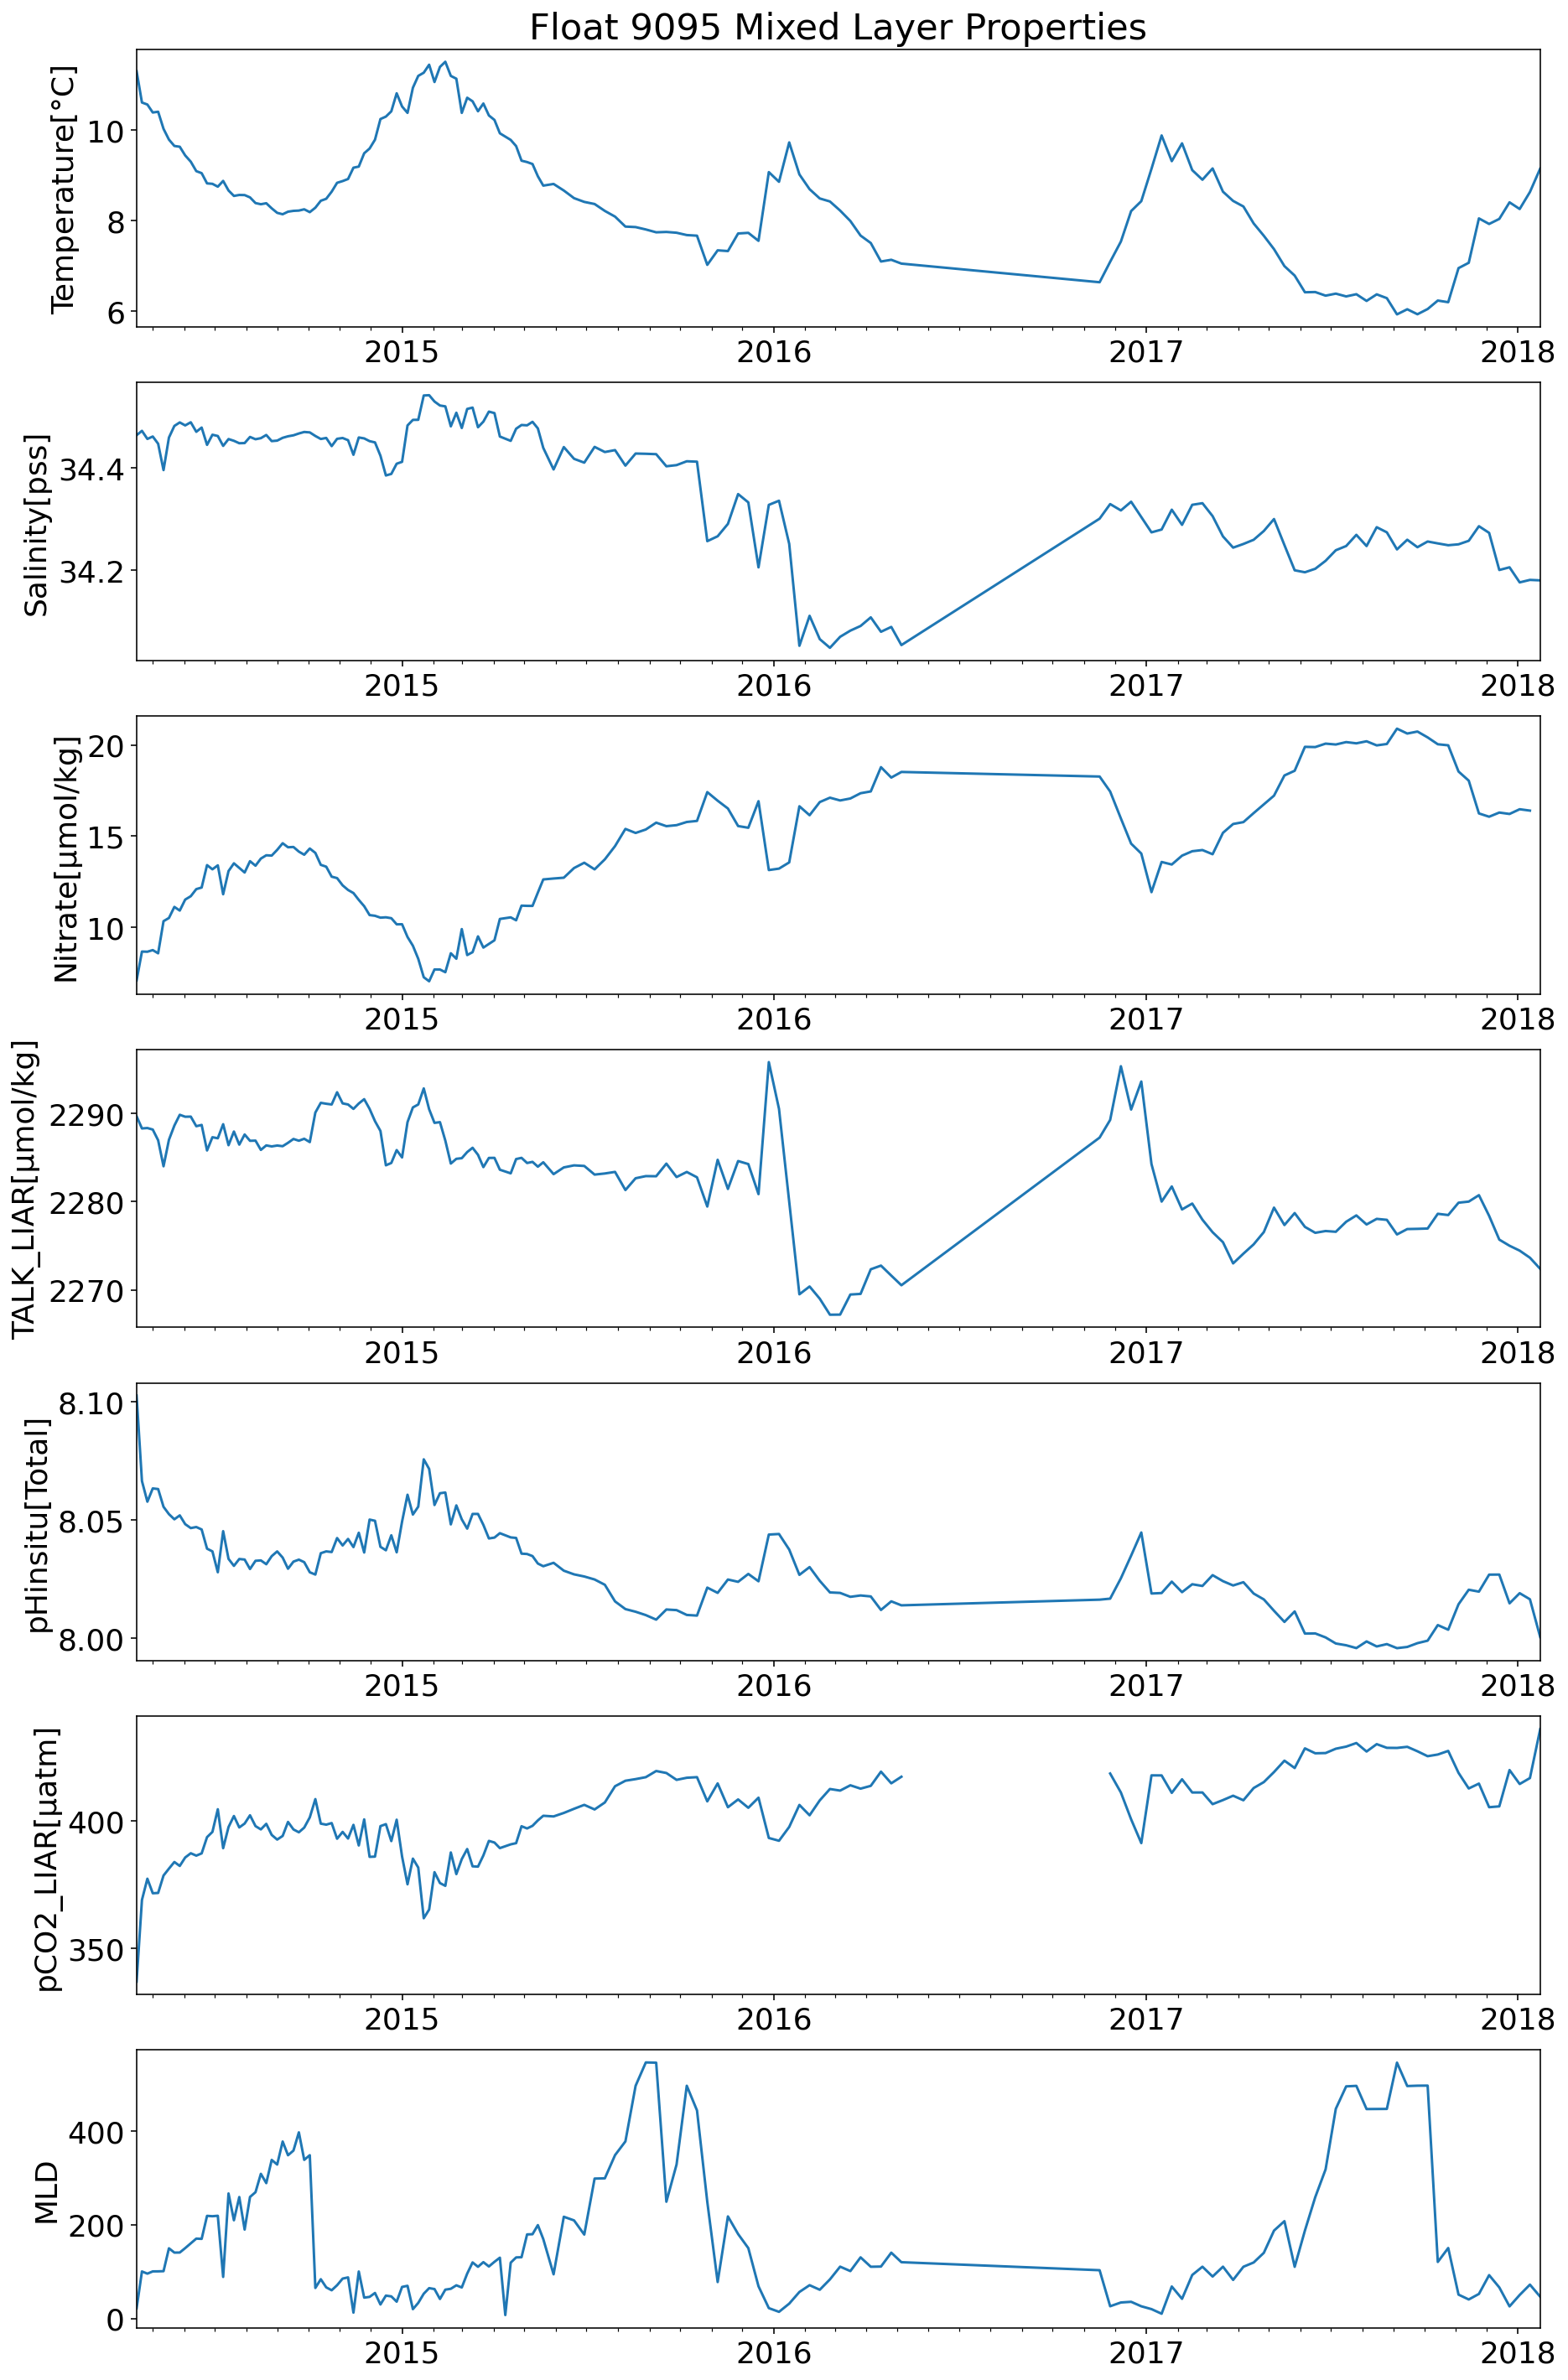

In [34]:
# Make a big plot with subplots
fig,axes = plt.subplots(nrows = 7, ncols = 1,figsize=(15,25))
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

var='Temperature[°C]'
axes[0].plot(fltdates,fltSurfByStn[var])
axes[0].set_ylabel(var)
axes[0].set_xlim(fltdates[0],fltdates[-1])
axes[0].xaxis.set_major_locator(years)
axes[0].xaxis.set_major_formatter(years_fmt)
axes[0].xaxis.set_minor_locator(months)

var='Salinity[pss]'
axes[1].plot(fltdates,fltSurfByStn[var])
axes[1].set_ylabel(var)
axes[1].set_xlim(fltdates[0],fltdates[-1])
axes[1].xaxis.set_major_locator(years)
axes[1].xaxis.set_major_formatter(years_fmt)
axes[1].xaxis.set_minor_locator(months)

var='Nitrate[µmol/kg]'
axes[2].plot(fltdates,fltSurfByStn[var])
axes[2].set_ylabel(var)
axes[2].set_xlim(fltdates[0],fltdates[-1])
axes[2].xaxis.set_major_locator(years)
axes[2].xaxis.set_major_formatter(years_fmt)
axes[2].xaxis.set_minor_locator(months)

var='TALK_LIAR[µmol/kg]'
axes[3].plot(fltdates,fltSurfByStn[var])
axes[3].set_ylabel(var)
axes[3].set_xlim(fltdates[0],fltdates[-1])
axes[3].xaxis.set_major_locator(years)
axes[3].xaxis.set_major_formatter(years_fmt)
axes[3].xaxis.set_minor_locator(months)

var='pHinsitu[Total]'
axes[4].plot(fltdates,fltSurfByStn[var])
axes[4].set_ylabel(var)
axes[4].set_xlim(fltdates[0],fltdates[-1])
axes[4].xaxis.set_major_locator(years)
axes[4].xaxis.set_major_formatter(years_fmt)
axes[4].xaxis.set_minor_locator(months)

var='pCO2_LIAR[µatm]'
axes[5].plot(fltdates,fltSurfByStn[var])
axes[5].set_ylabel(var)
axes[5].set_xlim(fltdates[0],fltdates[-1])
axes[5].xaxis.set_major_locator(years)
axes[5].xaxis.set_major_formatter(years_fmt)
axes[5].xaxis.set_minor_locator(months)

var='MLD'
axes[6].plot(MLD['date'],MLD['MLD'])
axes[6].set_ylabel(var)
axes[6].set_xlim(fltdates[0],fltdates[-1])
axes[6].xaxis.set_major_locator(years)
axes[6].xaxis.set_major_formatter(years_fmt)
axes[6].xaxis.set_minor_locator(months)

axes[0].set_title('Float ' + floatnum + ' Mixed Layer Properties')
fig.savefig(output_dir + 'F' + floatnum + 'MLD.png', dpi = 200, bbox_inches='tight')

## Mixed layer decomposition
Next, we will do a simple decomposition of the drivers of DIC and TA over the annual cycle. This simple decomposition does not account for the differences between processes which might add/subtract DIC and TA from the mixed layer through physical processes. 

The first step is to use the built in pandas.diff() function to take the differences between each station and the last. This will serve as our "Deltas" or changes in mixed layer depth properties between stations.

In [35]:
Deltas = fltSurfByStn.diff()
debug(Deltas)
debug(fltSurfByStn)

     Station  Cruise  Lon [°E]  Lat [°N]   QF  Pressure[dbar]  QF.1  \
0        NaN     NaN       NaN       NaN  NaN             NaN   NaN   
1        1.0     0.0     1.197     0.257  0.0       35.568095   0.0   
2        1.0     0.0     1.042    -0.538  0.0        1.586905   0.0   
3        1.0     0.0     0.282    -0.779  0.0        2.461667   0.0   
4        1.0     0.0     1.268    -0.425  0.0        0.045263   0.0   
..       ...     ...       ...       ...  ...             ...   ...   
149      1.0     0.0     0.355     0.005  0.0      -10.516154   0.0   
150      1.0     0.0     0.020     0.049  0.0      -21.945231   0.0   
151      1.0     0.0     0.147    -0.180  0.0       14.307111   0.0   
152      1.0     0.0     0.688     0.252  0.0       10.918889   0.0   
153      1.0     0.0     0.754    -0.009  0.0      -14.588750   0.0   

     Temperature[°C]  QF.2  Salinity[pss]  ...  pHinsitu[Total]  QF.14  \
0                NaN   NaN            NaN  ...              NaN    NaN   

In [36]:
## Now what if we want to get really fancy and add the supply of "things" from below (entrainment)?
# First let's calculate the sub-mixed layer values
fltSubMLD = pd.DataFrame()
for station in fltSurfByStn['Station'].unique(): 
    # If you use MLD['Station'] you get a different number of stations
    # because presumably there is some data missing from the MLD and so it doesn't get appended?
    stationMLD = MLD.MLD[MLD.Station==station].values[0]
    mask = (flt['Station']==station) & (flt['Pressure[dbar]']>stationMLD+10) & (flt['Pressure[dbar]']<stationMLD+50)
    fltSubMLD = fltSubMLD.append(flt[mask])
debug(fltSubMLD)

        Cruise  Station Type  mon/day/yr  hh:mm  Lon [°E]  Lat [°N]  QF  \
52     5904188        1    C  04/15/2014  06:56   210.110   -49.932   0   
53     5904188        1    C  04/15/2014  06:56   210.110   -49.932   0   
54     5904188        1    C  04/15/2014  06:56   210.110   -49.932   0   
55     5904188        1    C  04/15/2014  06:56   210.110   -49.932   0   
56     5904188        1    C  04/15/2014  06:56   210.110   -49.932   0   
...        ...      ...  ...         ...    ...       ...       ...  ..   
10009  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   
10010  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   
10011  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   
10012  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   
10013  5904188      173    C  01/22/2018  18:21   243.415   -49.121   0   

       Pressure[dbar]  QF.1  ...  QF.14  pH25C[Total]  QF.15  \
52              67.89   0.0  ...   

In [37]:
fltSubMLDByStn = fltSubMLD.groupby('Station',as_index=False).mean()
debug(fltSubMLDByStn)

     Station   Cruise  Lon [°E]  Lat [°N]  QF  Pressure[dbar]  QF.1  \
0          1  5904188   210.110   -49.932   0       50.311111   0.0   
1          2  5904188   211.307   -49.675   0      125.630000   0.0   
2          3  5904188   212.349   -50.213   0      126.405000   0.0   
3          4  5904188   212.631   -50.992   0      126.410000   0.0   
4          5  5904188   213.899   -51.417   0      126.300000   0.0   
..       ...      ...       ...       ...  ..             ...   ...   
133      169  5904188   241.806   -49.233   0       94.550000   0.0   
134      170  5904188   241.826   -49.184   0       55.961429   0.0   
135      171  5904188   241.973   -49.364   0       76.792857   0.0   
136      172  5904188   242.661   -49.112   0      102.552000   0.0   
137      173  5904188   243.415   -49.121   0       73.870000   0.0   

     Temperature[°C]  QF.2  Salinity[pss]  ...  pHinsitu[Total]  QF.14  \
0          10.835022   0.0      34.465011  ...         8.097956    0.0   

In [103]:
# When the mixed layer is deepening (dMLD is positive) calculate dN_dMLD
dN_dMLD = pd.DataFrame()
dTA_dMLD = pd.DataFrame()
dDIC_dMLD = pd.DataFrame()
for station in fltSurfByStn['Station'].unique():
    if station == 1: # to turn off this block, make it read "if False and ___"
        dN_dMLD = dN_dMLD.append([0], ignore_index=True)
        dTA_dMLD = dTA_dMLD.append([0], ignore_index=True)
        dDIC_dMLD = dDIC_dMLD.append([0], ignore_index=True)
        
        lastSubML = fltSubMLDByStn.loc[fltSubMLDByStn['Station'] == station]
        lastML = fltSurfByStn.loc[fltSurfByStn['Station'] == station]
        lastMLD = MLD.MLD[MLD.Station == station].values[0]
        continue
    
    if (len(lastSubML) == 0) or (len(lastML) == 0):
        dN_dMLD = dN_dMLD.append([0], ignore_index=True)
        dTA_dMLD = dTA_dMLD.append([0], ignore_index=True)
        dDIC_dMLD = dDIC_dMLD.append([0], ignore_index=True)
        
        lastSubML = fltSubMLDByStn.loc[fltSubMLDByStn['Station'] == station]
        lastML = fltSurfByStn.loc[fltSurfByStn['Station'] == station]
        lastMLD = MLD.MLD[MLD.Station == station].values[0]
        continue
    
    MLDt2 = MLD.MLD[MLD.Station == station].values[0]
    dMLD = MLDt2 - lastMLD
    if dMLD > 0: # i.e., only if the mixed layer is deepening
        # Calculate the change in mixed layer content from the entrainment
        # Use the surface mixed layer and sub-mixed layer values from the last station
        dN = ((lastSubML['Nitrate[µmol/kg]'].values[0] * lastMLD +
               lastML['Nitrate[µmol/kg]'].values[0] * dMLD) /
              MLDt2) - lastSubML['Nitrate[µmol/kg]'].values[0]
        dTA = ((lastSubML['TALK_LIAR[µmol/kg]'].values[0] * lastMLD +
               lastML['TALK_LIAR[µmol/kg]'].values[0] * dMLD) /
              MLDt2) - lastSubML['TALK_LIAR[µmol/kg]'].values[0]
        dDIC = ((lastSubML['DIC_LIAR[µmol/kg]'].values[0] * lastMLD +
               lastML['DIC_LIAR[µmol/kg]'].values[0] * dMLD) /
              MLDt2) - lastSubML['DIC_LIAR[µmol/kg]'].values[0]
        
        #dN = [(A['Nitrate[µmol/kg]'].values[0] - B['Nitrate[µmol/kg]'].values[0]) * dMLD / MLDt1]
        #dTA = [(A['TALK_LIAR[µmol/kg]'].values[0] - B['TALK_LIAR[µmol/kg]'].values[0]) * dMLD / MLDt2]
        #dDIC = [(A['DIC_LIAR[µmol/kg]'].values[0] - B['DIC_LIAR[µmol/kg]'].values[0]) * dMLD / MLDt2]
        
        debug (station, dMLD, dN)
        
        dN_dMLD = dN_dMLD.append(pd.DataFrame([dN]), ignore_index=True)
        dTA_dMLD = dTA_dMLD.append(pd.DataFrame([dTA]), ignore_index=True)
        dDIC_dMLD = dDIC_dMLD.append(pd.DataFrame([dDIC]), ignore_index=True)
        
        lastSubML = fltSubMLDByStn.loc[fltSubMLDByStn['Station'] == station]
        lastML = fltSurfByStn.loc[fltSurfByStn['Station'] == station]
        lastMLD = MLD.MLD[MLD.Station == station].values[0]
      
    else:
        dN_dMLD = dN_dMLD.append([0], ignore_index=True)
        dTA_dMLD = dTA_dMLD.append([0], ignore_index=True)
        dDIC_dMLD = dDIC_dMLD.append([0], ignore_index=True)
        
        lastSubML = fltSubMLDByStn.loc[fltSubMLDByStn['Station'] == station]
        lastML = fltSurfByStn.loc[fltSurfByStn['Station'] == station]
        lastMLD = MLD.MLD[MLD.Station == station].values[0]

2 78.679 -0.7264501108081518
4 4.8289999999999935 -0.18961054202947558
5 0.09499999999999886 -0.0038222193435242247
6 0.38299999999999557 -0.016722706286248723
7 48.75800000000001 -1.00878048494258
9 0.12100000000000932 -0.0030361324857821614
10 9.409999999999997 -0.2739915954862635
11 10.233000000000004 -0.2620320403931906
12 10.048000000000002 -0.21903400832873032
14 49.08099999999999 -0.8128773529804239
16 0.9120000000000061 -0.014522695405617014
18 178.03600000000003 -1.0426057821162882
20 49.56800000000004 -0.6610483677603227
22 69.566 -1.001132236095346
23 10.178999999999974 -0.14935872377279935
24 39.19 -0.38378834112126725
26 49.452 -0.5539589868795893
28 49.108000000000004 -0.3691515992556411
30 9.985000000000014 -0.07207406794799454
31 38.84699999999998 -0.28669656642958685
33 9.973000000000013 -0.09741106191925297
35 18.614000000000004 -0.055925179755266896
38 10.744000000000007 -0.15434143558523594
39 14.143 -0.13306320763208035
40 2.5659999999999883 -0.04543163731991662
42

In [104]:
debug(len(dN_dMLD), len(dTA_dMLD), len(dDIC_dMLD))

154 154 154


In [105]:
dN_dS = Deltas['Salinity[pss]'] * fltSurfByStn['Nitrate[µmol/kg]'].iloc[0] / fltSurfByStn['Salinity[pss]'].iloc[0]
dTA_dS = Deltas['Salinity[pss]'] * fltSurfByStn['TALK_LIAR[µmol/kg]'].iloc[0] / fltSurfByStn['Salinity[pss]'].iloc[0]
dDIC_dS = Deltas['Salinity[pss]'] * fltSurfByStn['DIC_LIAR[µmol/kg]'].iloc[0] / fltSurfByStn['Salinity[pss]'].iloc[0]

debug(dDIC_dS)

0           NaN
1      0.508298
2     -0.946380
3      0.284346
4     -0.846184
         ...   
149   -4.343118
150    0.315493
151   -1.763816
152    0.290354
153   -0.054200
Name: Salinity[pss], Length: 154, dtype: float64


In [106]:
# Net Community Metabolism (respiration - photosynthesis)

# Squeeze turns this dataframe into a series so we can do math with it and these other series
dN_NCM = Deltas['Nitrate[µmol/kg]'] - dN_dS - dN_dMLD.squeeze() 
C_to_N = 117 / 16
TA_to_N = -16 / 16
dDIC_NCM = dN_NCM * C_to_N
dTA_NCM = dN_NCM * TA_to_N

dDIC_NCM

0            NaN
1      16.881063
2      -0.040754
3       2.030486
4      -1.236350
         ...    
149     1.779231
150    -0.572639
151     2.140467
152     0.690902
153          NaN
Length: 154, dtype: float64

In [107]:
# Calcification and Dissolution
dTA_CaCO3 = Deltas['TALK_LIAR[µmol/kg]'] - dTA_dS - dTA_NCM - dTA_dMLD.squeeze()
DIC_to_TA_calc = 0.5
dDIC_CaCO3 = dTA_CaCO3 * DIC_to_TA_calc

debug(dTA_CaCO3)

0           NaN
1     -0.594758
2      1.088181
3     -0.143849
4     -0.441532
         ...   
149    2.351919
150   -1.119366
151    2.035005
152   -0.858211
153         NaN
Length: 154, dtype: float64


In [108]:
# Residual term- this represents physics that we didn't explicitly account for, and gas exchange
dDIC_resid = Deltas['DIC_LIAR[µmol/kg]'] - dDIC_dS - dDIC_NCM - dDIC_CaCO3 - dDIC_dMLD.squeeze()
dDIC_resid

0           NaN
1      5.916379
2      4.601774
3     -2.238360
4      1.122444
         ...   
149   -1.227458
150    3.047598
151   -2.601596
152   -1.834010
153         NaN
Length: 154, dtype: float64

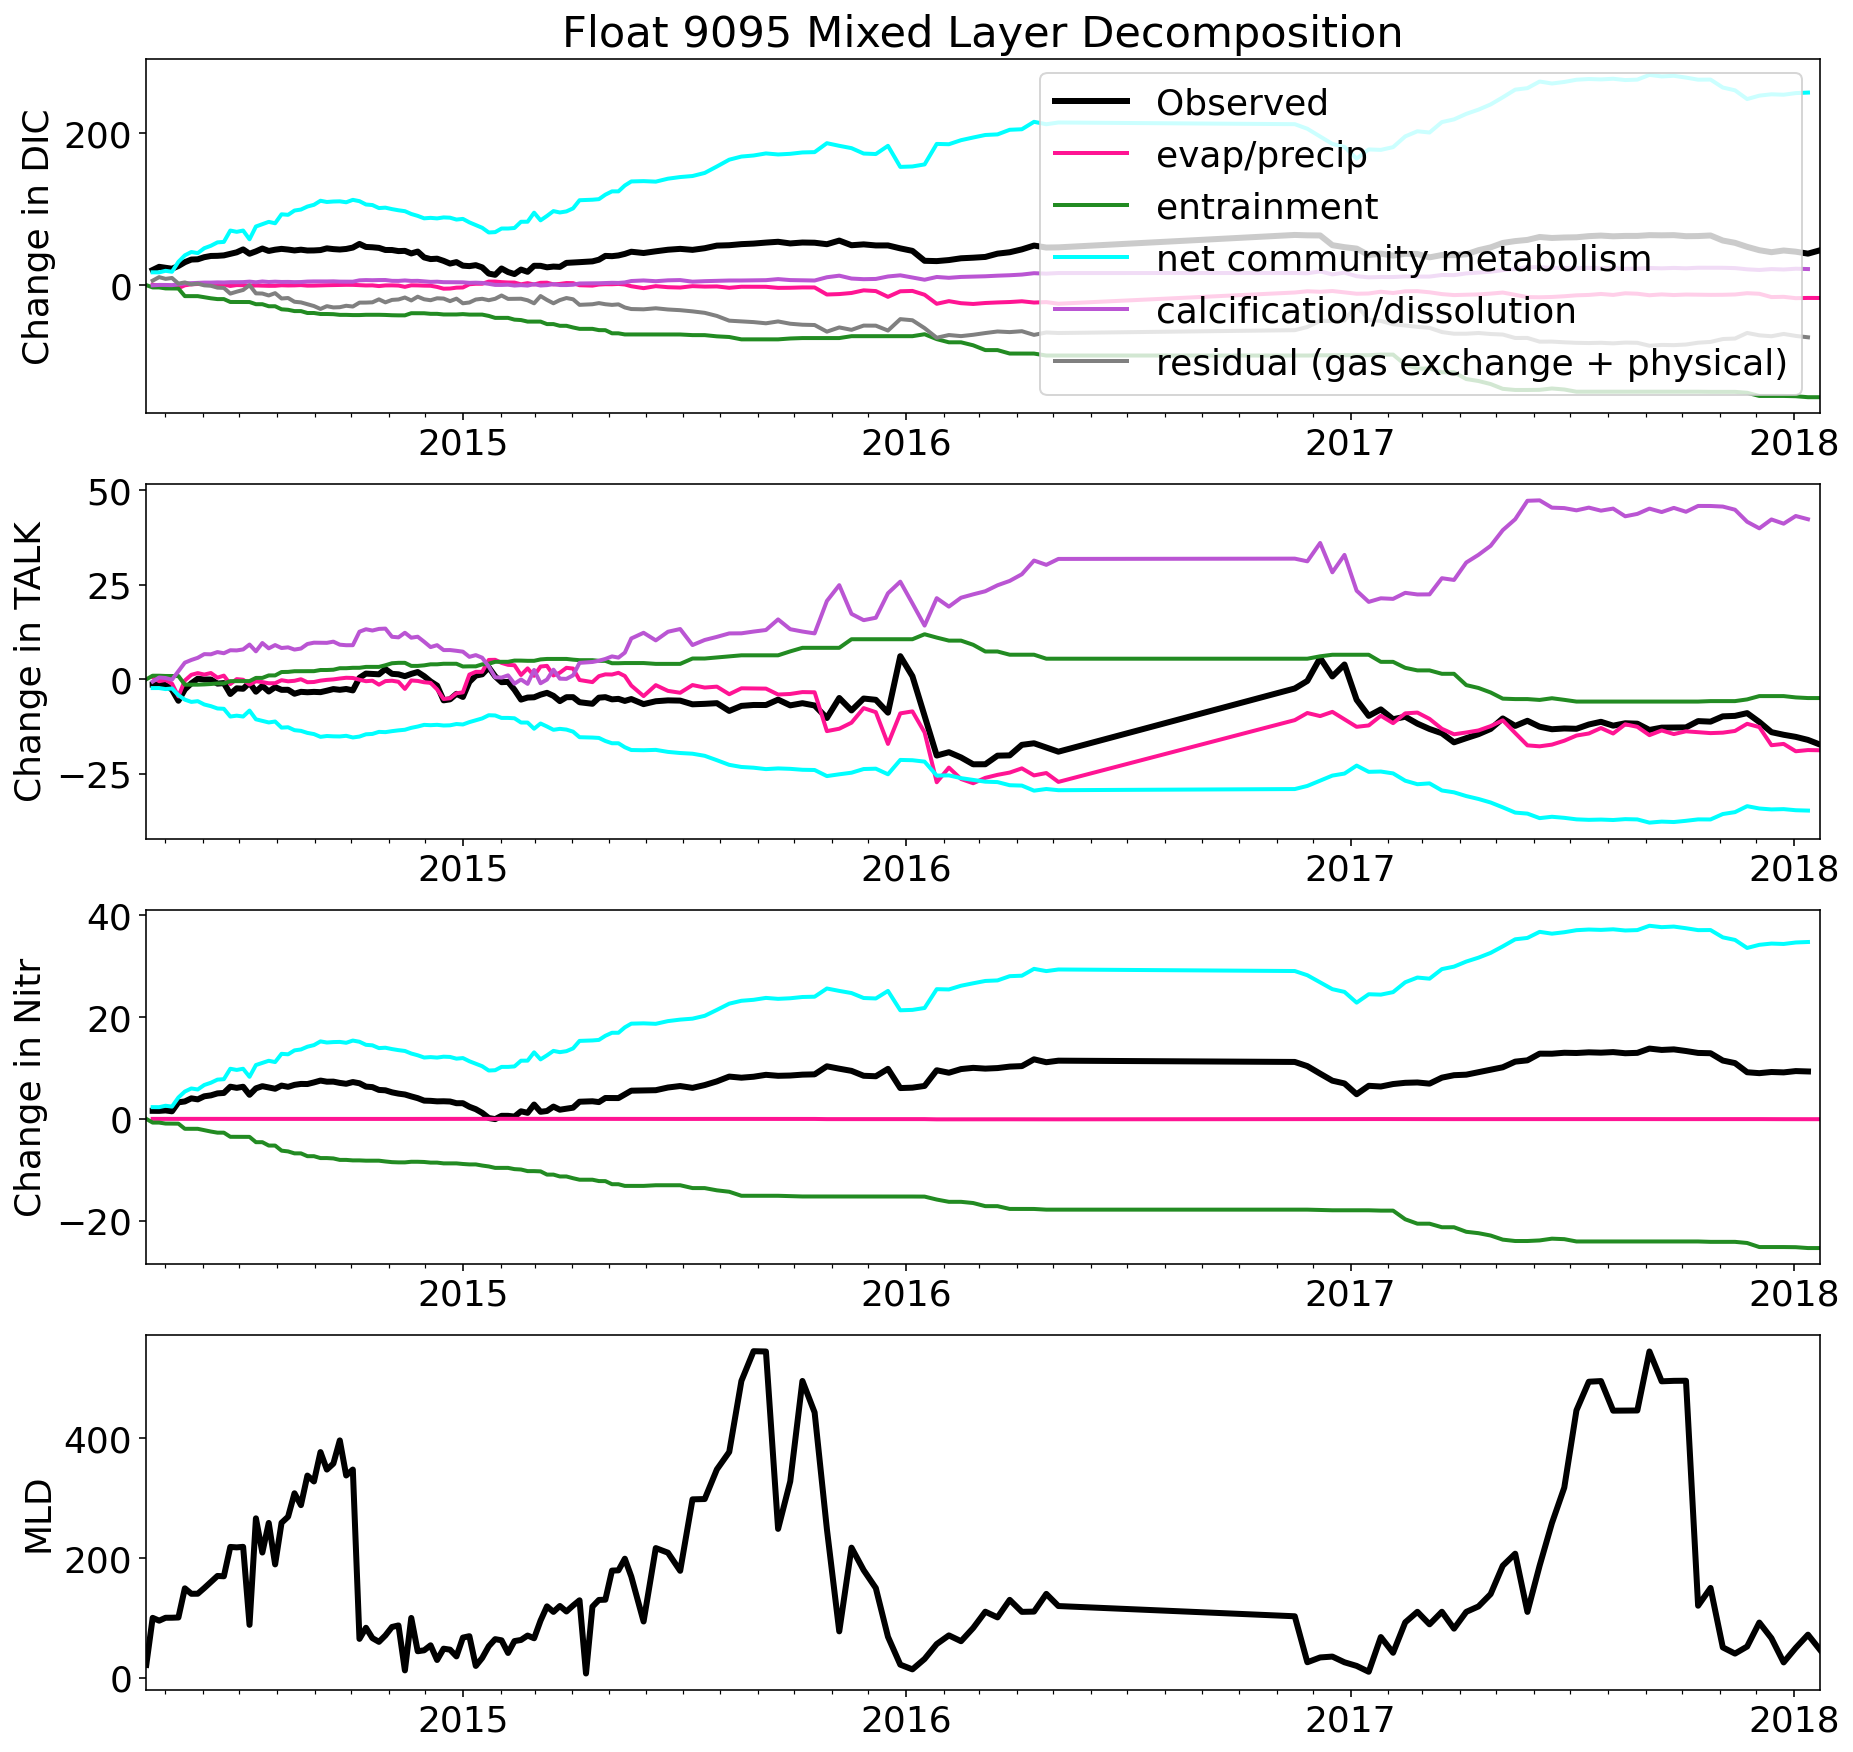

In [109]:
# Make a big plot with subplots
fig,axes = plt.subplots(nrows = 4, ncols = 1,figsize=(15,15))
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

var='DIC_LIAR[µmol/kg]'
axes[0].plot(fltdates,Deltas[var].cumsum(), label='Observed', c='black', linewidth=3)
axes[0].set_ylabel('Change in ' + var[:3])
axes[0].plot(fltdates,dDIC_dS.cumsum(), label='evap/precip', c='deeppink', linewidth=2)
axes[0].plot(fltdates,dDIC_dMLD[0].cumsum(), label='entrainment', c='forestgreen', linewidth=2)
axes[0].plot(fltdates,dDIC_NCM.cumsum(), label='net community metabolism', c='cyan', linewidth=2)
axes[0].plot(fltdates,dDIC_CaCO3.cumsum(), label='calcification/dissolution', c='mediumorchid', linewidth=2)
axes[0].plot(fltdates,dDIC_resid.cumsum(), label='residual (gas exchange + physical)', c='grey', linewidth=2)
axes[0].set_xlim(fltdates[0], fltdates[-1])
axes[0].xaxis.set_major_locator(years)
axes[0].xaxis.set_major_formatter(years_fmt)
axes[0].xaxis.set_minor_locator(months)
axes[0].legend()

var='TALK_LIAR[µmol/kg]'
axes[1].plot(fltdates,Deltas[var].cumsum(), label='Observed', c='black', linewidth=3)
axes[1].set_ylabel('Change in ' + var[:4])
axes[1].plot(fltdates,dTA_dS.cumsum(), label='evap/precip', c='deeppink', linewidth=2)
axes[1].plot(fltdates,dTA_dMLD[0].cumsum(), label='entrainment', c='forestgreen', linewidth=2)
axes[1].plot(fltdates,dTA_NCM.cumsum(), label='net community metabolism', c='cyan', linewidth=2)
axes[1].plot(fltdates,dTA_CaCO3.cumsum(), label='calcification/dissolution', c='mediumorchid', linewidth=2)
axes[1].set_xlim(fltdates[0], fltdates[-1])
axes[1].xaxis.set_major_locator(years)
axes[1].xaxis.set_major_formatter(years_fmt)
axes[1].xaxis.set_minor_locator(months)
#axes[1].legend()

var = 'Nitrate[µmol/kg]'
axes[2].plot(fltdates,Deltas[var].cumsum(), label='Observed', c='black', linewidth=3)
axes[2].set_ylabel('Change in ' + var[:4])
axes[2].plot(fltdates,dN_dS.cumsum(), label='evap/precip', c='deeppink', linewidth=2)
axes[2].plot(fltdates,dN_dMLD[0].cumsum(), label='entrainment', c='forestgreen', linewidth=2)
axes[2].plot(fltdates,dN_NCM.cumsum(), label='net community metabolism', c='cyan', linewidth=2)
axes[2].set_xlim(fltdates[0], fltdates[-1])
axes[2].xaxis.set_major_locator(years)
axes[2].xaxis.set_major_formatter(years_fmt)
axes[2].xaxis.set_minor_locator(months)
#axes[2].legend()

var = 'MLD'
axes[3].plot(MLD['date'],MLD['MLD'], label='Observed', c='black', linewidth=3)
axes[3].set_ylabel(var)
axes[3].set_xlim(fltdates[0], fltdates[-1])
axes[3].xaxis.set_major_locator(years)
axes[3].xaxis.set_major_formatter(years_fmt)
axes[3].xaxis.set_minor_locator(months)

axes[0].set_title('Float ' + floatnum + ' Mixed Layer Decomposition')
fig.savefig(output_dir + 'F' + floatnum + 'MLDecomp.png', dpi = 200, bbox_inches='tight')